[*********************100%%**********************]  1 of 1 completed
Annual Mean, Median, and Mode of Prices:
      XRP-USD_mean  XRP-USD_median  XRP-USD_mode
Year                                            
2017      0.575206        0.252393      0.197339
2018      0.666274        0.506698      0.263710
2019      0.309701        0.308992      0.183699
2020      0.258399        0.236176      0.139635
2021      0.868009        0.893689      0.221655
2022      0.513003        0.422337      0.308090
2023      0.512771        0.503298      0.338039
2024      0.607245        0.548033      0.419823

Monthly Prices and Standard Deviations:
            XRP-USD_price  XRP-USD_std
Date                                  
2017-11-30       0.250878     0.022663
2017-12-31       2.300570     0.612478
2018-01-31       1.162390     0.693223
2018-02-28       0.904583     0.133684
2018-03-31       0.512353     0.140076
...                   ...          ...
2024-08-31       0.566313     0.029120
2024-09-

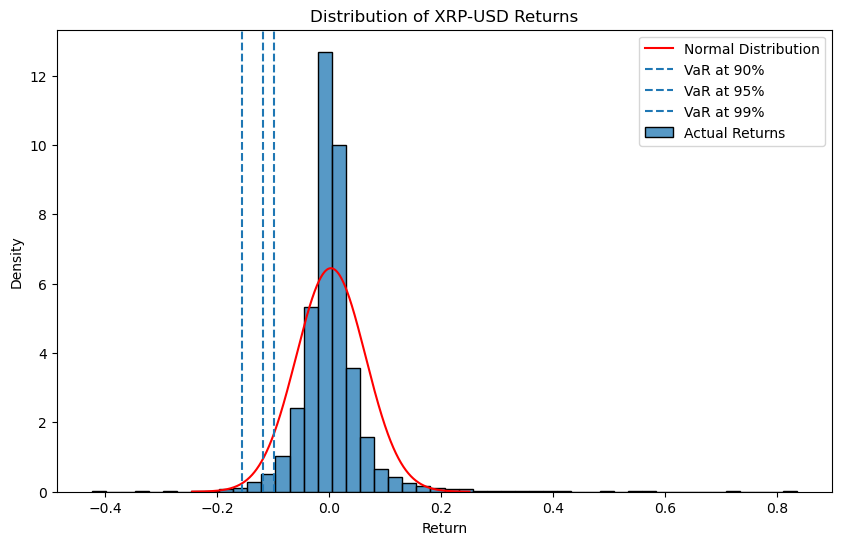


Average Returns by Season:
         XRP-USD
Season          
Autumn  0.004960
Spring  0.002238
Summer -0.000185
Winter  0.003800


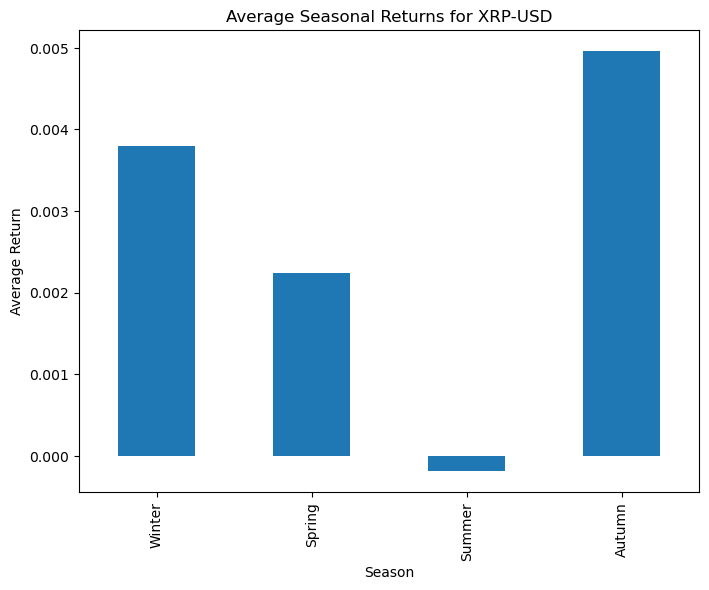


Price Extremes and Deviation:
         Current Price  Mean Price  Deviation (%)  All-Time High Price  \
XRP-USD       2.525527    0.533606     373.294359              3.37781   

        All-Time High Date  52-Week High Price 52-Week High Date  
XRP-USD         2018-01-07            2.713805        2024-12-02  

Top 10 Months with Returns Higher Than 6%:
           Ticker       Date  Monthly Return
0  XRP-USD_return 2017-12-31        8.170075
1  XRP-USD_return 2024-11-30        2.817714
2  XRP-USD_return 2021-04-30        1.773584
3  XRP-USD_return 2020-11-30        1.771027
4  XRP-USD_return 2021-01-31        1.239359
5  XRP-USD_return 2018-09-30        0.734317
6  XRP-USD_return 2018-04-30        0.635470
7  XRP-USD_return 2021-08-31        0.588146
8  XRP-USD_return 2023-07-31        0.473558
9  XRP-USD_return 2020-07-31        0.472133

Sharpe Ratio:
XRP-USD    0.695504
dtype: float64

Sortino Ratio:
XRP-USD    1.398257
dtype: float64

Maximum Drawdown:
{'XRP-USD': -0.958661086148

In [1]:
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


class AssetAnalysis:
    def __init__(self, tickers, start_date, end_date):
        if isinstance(tickers, str):
            self.tickers = [tickers]
        else:
            self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = yf.download(self.tickers, start=start_date, end=end_date, interval='1d')['Adj Close'].dropna()
        if len(self.tickers) == 1:
            self.data = self.data.to_frame(name=self.tickers[0])
        self.returns = self.data.pct_change().dropna()
        # Ensure that returns DataFrame has proper columns
        self.returns.columns = self.tickers
    
    def compute_mode(self, series):
        mode_series = series.mode()
        return mode_series.iloc[0] if not mode_series.empty else np.nan

    def annual_statistics(self):
        # Compute annual statistics based on prices
        annual_stats = self.data.groupby(self.data.index.year).agg(['mean', 'median'])
        annual_mode = self.data.groupby(self.data.index.year).agg(self.compute_mode)
        annual_mode.columns = [col + '_mode' for col in annual_mode.columns]
        annual_summary = pd.concat([annual_stats, annual_mode], axis=1)
        annual_summary.index.name = 'Year'
        annual_summary.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in annual_summary.columns.values]
        return annual_summary

    def monthly_statistics(self):
        monthly_prices = self.data.resample('ME').ffill()
        monthly_prices.columns = [col + '_price' for col in monthly_prices.columns]
        monthly_std = self.data.resample('ME').std()
        monthly_std.columns = [col + '_std' for col in monthly_std.columns]
        monthly_summary = monthly_prices.join(monthly_std)
        return monthly_summary

    def value_at_risk(self, confidence_levels):
        z_scores = [stats.norm.ppf(1 - (1 - cl)/2) for cl in confidence_levels]
        mean_returns = self.returns.mean()
        std_returns = self.returns.std()
        VaR_df = pd.DataFrame(index=[f"{int(cl * 100)}%" for cl in confidence_levels], columns=self.tickers)
        for cl, z in zip(confidence_levels, z_scores):
            VaR_values = mean_returns - z * std_returns
            VaR_df.loc[f"{int(cl * 100)}%"] = VaR_values
        return VaR_df

    def plot_distributions(self, confidence_levels):
        z_scores = [stats.norm.ppf(1 - (1 - cl)/2) for cl in confidence_levels]
        mean_returns = self.returns.mean()
        std_returns = self.returns.std()
        for ticker in self.tickers:
            plt.figure(figsize=(10, 6))
            sns.histplot(self.returns[ticker], kde=False, stat='density', bins=50, label='Actual Returns')
            mean = mean_returns[ticker]
            std = std_returns[ticker]
            x = np.linspace(mean - 4 * std, mean + 4 * std, 1000)
            y = stats.norm.pdf(x, mean, std)
            plt.plot(x, y, label='Normal Distribution', color='red')
            for cl, z in zip(confidence_levels, z_scores):
                VaR = mean - z * std
                plt.axvline(VaR, linestyle='--', label=f'VaR at {int(cl * 100)}%')
            plt.title(f'Distribution of {ticker} Returns')
            plt.xlabel('Return')
            plt.ylabel('Density')
            plt.legend()
            plt.show()

    def seasonal_analysis(self):
        # Perform seasonal analysis based on returns
        returns = self.returns.copy()
        returns['Month'] = returns.index.month
        returns['Season'] = returns['Month'].apply(lambda x: (1 if x in [12,1,2] else 2 if x in [3,4,5] else 3 if x in [6,7,8] else 4))
        season_dict = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
        returns['Season'] = returns['Season'].map(season_dict)
        seasonal_returns = returns.groupby('Season').mean()[self.tickers]
        return seasonal_returns

    def plot_seasonal_returns(self):
        # Plot average seasonal returns
        returns = self.returns.copy()
        returns['Month'] = returns.index.month
        returns['Season'] = returns['Month'].apply(lambda x: (1 if x in [12,1,2] else 2 if x in [3,4,5] else 3 if x in [6,7,8] else 4))
        season_dict = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
        returns['Season'] = returns['Season'].map(season_dict)
        season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
        for ticker in self.tickers:
            seasonal_data = returns.groupby('Season')[ticker].mean().reindex(season_order)
            plt.figure(figsize=(8,6))
            seasonal_data.plot(kind='bar')
            plt.title(f'Average Seasonal Returns for {ticker}')
            plt.ylabel('Average Return')
            plt.xlabel('Season')
            plt.show()

    def price_deviation(self):
        current_price = self.data.iloc[-1][self.tickers]
        mean_price = self.data[self.tickers].mean()
        deviation = ((current_price - mean_price) / mean_price) * 100
        deviation_df = pd.DataFrame({
            'Current Price': current_price,
            'Mean Price': mean_price,
            'Deviation (%)': deviation
        })
        return deviation_df

    def price_extremes(self):
        current_price = self.data.iloc[-1][self.tickers]
        mean_price = self.data[self.tickers].mean()
        deviation = ((current_price - mean_price) / mean_price) * 100
        ath_price = self.data[self.tickers].max()
        ath_date = self.data[self.tickers].idxmax()
        # Calculate 52-week high
        last_52_weeks = self.data[self.tickers].loc[self.data.index[-1] - pd.DateOffset(weeks=52):]
        high_52week_price = last_52_weeks.max()
        high_52week_date = last_52_weeks.idxmax()
        extremes_df = pd.DataFrame({
            'Current Price': current_price,
            'Mean Price': mean_price,
            'Deviation (%)': deviation,
            'All-Time High Price': ath_price,
            'All-Time High Date': ath_date,
            '52-Week High Price': high_52week_price,
            '52-Week High Date': high_52week_date
        })
        return extremes_df

    def top_high_returns(self, threshold=0.06, top_n=10):
        price_data = self.data[self.tickers]  # Ensure we only have price columns
        monthly_returns = price_data.resample('ME').ffill().pct_change().dropna()
        monthly_returns.columns = [col + '_return' for col in monthly_returns.columns]
        high_return_months = monthly_returns[monthly_returns > threshold].dropna(how='all')
        top_months = high_return_months.unstack().dropna().sort_values(ascending=False).head(top_n)
        top_months = top_months.reset_index()
        top_months.columns = ['Ticker', 'Date', 'Monthly Return']
        return top_months

    def sharpe_ratio(self, risk_free_rate=0.0):
        excess_returns = self.returns[self.tickers] - risk_free_rate / 252
        mean_excess_return = excess_returns.mean()
        std_dev = self.returns[self.tickers].std()
        sharpe_ratio = mean_excess_return / std_dev * np.sqrt(252)
        return sharpe_ratio

    def sortino_ratio(self, risk_free_rate=0.0):
        excess_returns = self.returns[self.tickers] - risk_free_rate / 252
        negative_returns = excess_returns.copy()
        negative_returns[negative_returns > 0] = 0
        downside_std = negative_returns.std()
        mean_excess_return = excess_returns.mean()
        sortino_ratio = mean_excess_return / downside_std * np.sqrt(252)
        return sortino_ratio

    def maximum_drawdown(self):
        drawdowns = {}
        for ticker in self.tickers:
            cumulative_returns = (1 + self.returns[ticker]).cumprod()
            peak = cumulative_returns.cummax()
            drawdown = (cumulative_returns - peak) / peak
            max_drawdown = drawdown.min()
            drawdowns[ticker] = max_drawdown
        return drawdowns

    def months_with_large_drawdowns(self, threshold=-0.10):
        price_data = self.data[self.tickers]
        monthly_returns = price_data.resample('ME').ffill().pct_change().dropna()
        large_drawdowns = monthly_returns[monthly_returns < threshold].dropna(how='all')
        drawdown_months = large_drawdowns.stack().reset_index()
        drawdown_months.columns = ['Date', 'Ticker', 'Monthly Return']
        drawdown_months = drawdown_months.sort_values(by='Date')
        return drawdown_months

    def yearly_peak_and_min_info(self):
        peak_info_list = []
        for ticker in self.tickers:
            df = self.data[[ticker]].copy()
            df['Year'] = df.index.year
            years = df['Year'].unique()
            for year in years:
                df_year = df[df['Year'] == year]
                # Check if df_year is empty
                if df_year.empty:
                    continue
                
                peak_price = df_year[ticker].max()
                peak_date = df_year[df_year[ticker] == peak_price].index[0]
                
                start_of_year = df_year.index.min()
                days_to_peak = (peak_date - start_of_year).days
                
                df_after_peak = df_year.loc[peak_date:]
                df_after_peak['Price Change'] = df_after_peak[ticker].diff()
                decline_start_dates = df_after_peak[df_after_peak['Price Change'] < 0].index
                decline_start_date = decline_start_dates[0] if not decline_start_dates.empty else peak_date
                
                df_after_decline_start = df_after_peak.loc[decline_start_date:]
                min_price_after_decline = df_after_decline_start[ticker].min()
                min_date_after_decline = df_after_decline_start[df_after_decline_start[ticker] == min_price_after_decline].index[0]
                days_from_decline_start_to_min = (min_date_after_decline - decline_start_date).days
               
                peak_info_list.append({
                    'Ticker': ticker,
                    'Year': year,
                    'Peak Date': peak_date.date(),
                    'Peak Price': peak_price,
                    'Days to Peak': days_to_peak,
                    'Decline Start Date': decline_start_date.date(),
                    'Minimum Date After Decline': min_date_after_decline.date(),
                    'Minimum Price After Decline': min_price_after_decline,
                    'Days from Decline Start to Minimum': days_from_decline_start_to_min
                })
        peak_info_df = pd.DataFrame(peak_info_list)
        return peak_info_df


tickers = 'XRP-USD' 
analysis = AssetAnalysis(tickers, start_date='2010-01-01', end_date='2024-12-04')

annual_summary = analysis.annual_statistics()
print("Annual Mean, Median, and Mode of Prices:")
print(annual_summary)

monthly_summary = analysis.monthly_statistics()
print("\nMonthly Prices and Standard Deviations:")
print(monthly_summary)

confidence_levels = [0.90, 0.95, 0.99]
VaR_df = analysis.value_at_risk(confidence_levels)
print("\nValue at Risk (VaR) at Different Confidence Levels:")
print(VaR_df)

analysis.plot_distributions(confidence_levels)

seasonal_returns = analysis.seasonal_analysis()
print("\nAverage Returns by Season:")
print(seasonal_returns)


analysis.plot_seasonal_returns()

deviation_df = analysis.price_extremes()
print("\nPrice Extremes and Deviation:")
print(deviation_df)

top_months = analysis.top_high_returns()
print("\nTop 10 Months with Returns Higher Than 6%:")
print(top_months)

sharpe_ratio = analysis.sharpe_ratio()
print("\nSharpe Ratio:")
print(sharpe_ratio)

sortino_ratio = analysis.sortino_ratio()
print("\nSortino Ratio:")
print(sortino_ratio)

max_drawdown = analysis.maximum_drawdown()
print("\nMaximum Drawdown:")
print(max_drawdown)

yearly_peak_info = analysis.yearly_peak_and_min_info()
print("\nYearly Peak and Minimum Information:")
print(yearly_peak_info)

drawdown_months = analysis.months_with_large_drawdowns(threshold=-0.10)
print("\nMonths with Drawdowns Exceeding 10%:")
print(drawdown_months)


[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  1 of 1 completed
Correlation Matrix:
          BTC-USD   ETH-USD   XRP-USD       XLE
BTC-USD  1.000000  0.911763  0.464623  0.531502
ETH-USD  0.911763  1.000000  0.565933  0.534149
XRP-USD  0.464623  0.565933  1.000000  0.135443
XLE      0.531502  0.534149  0.135443  1.000000


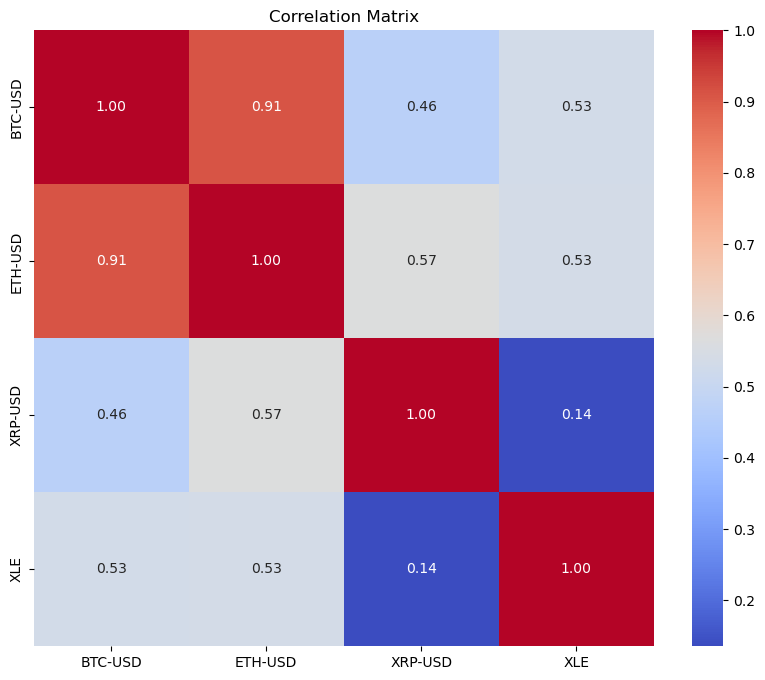

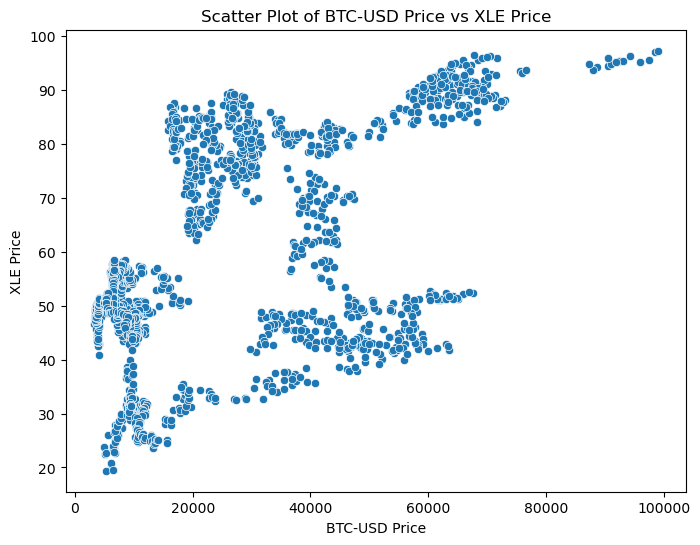

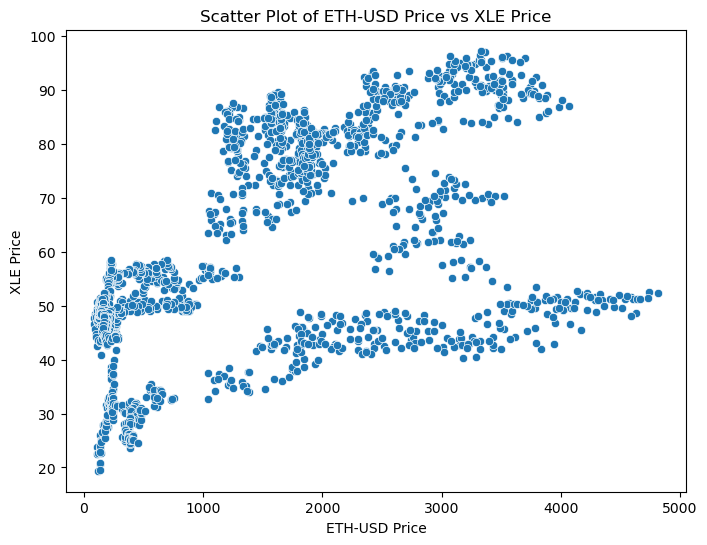

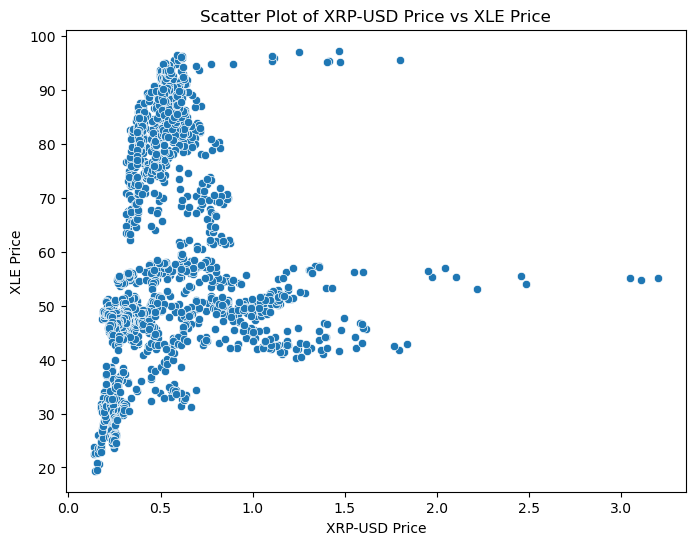

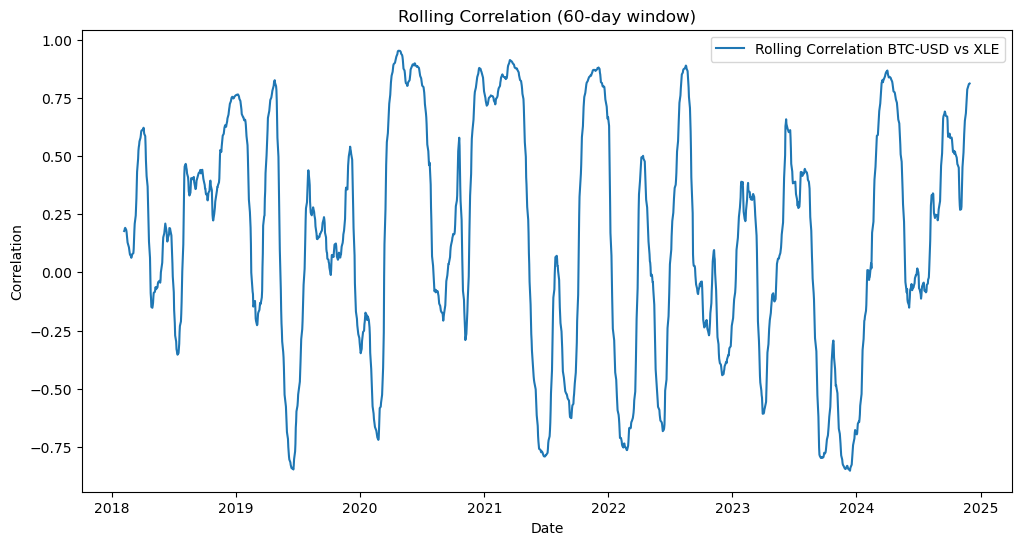

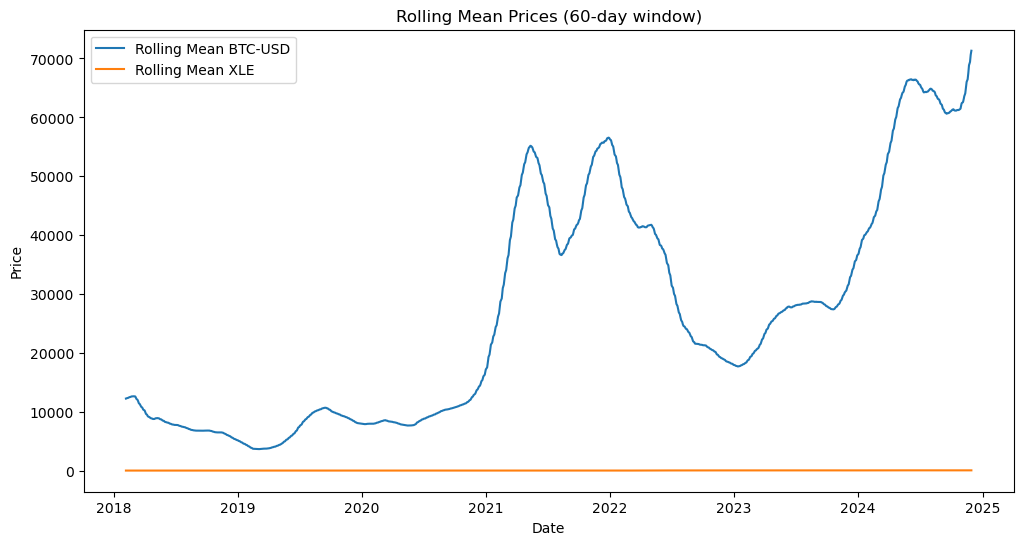

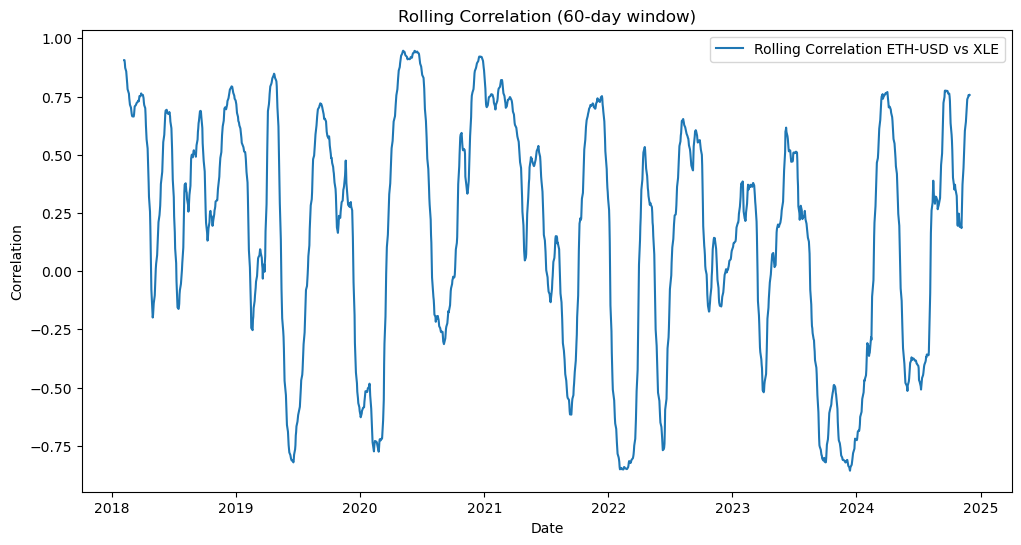

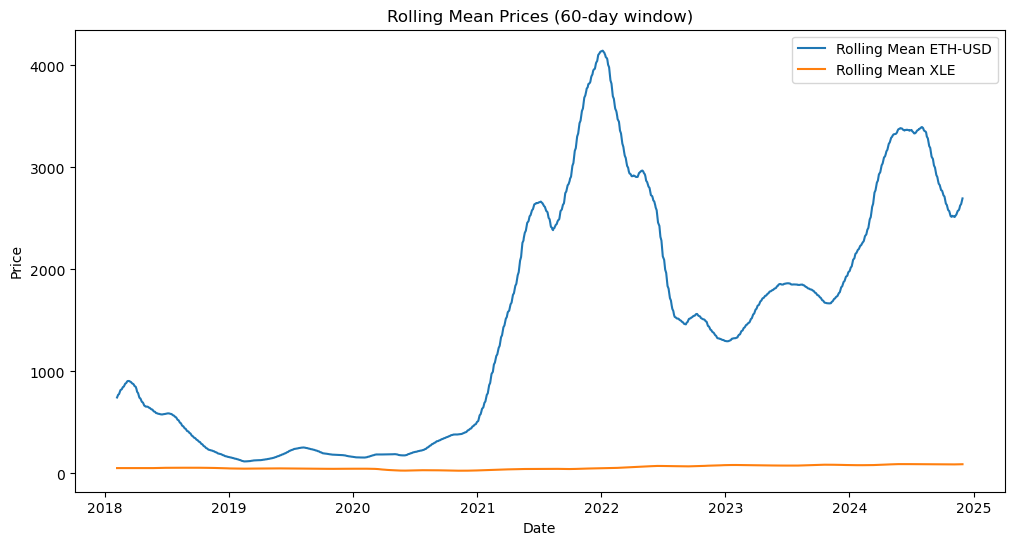

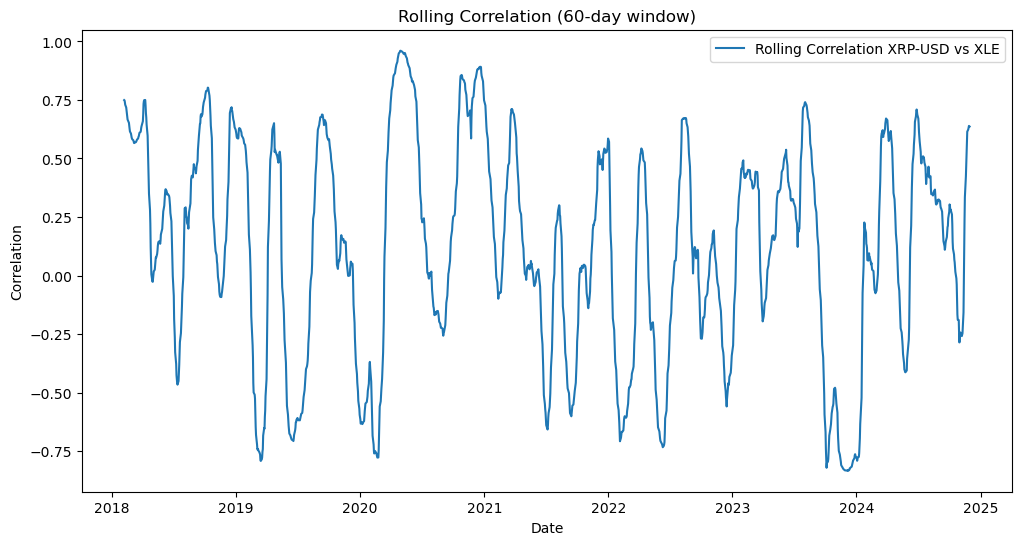

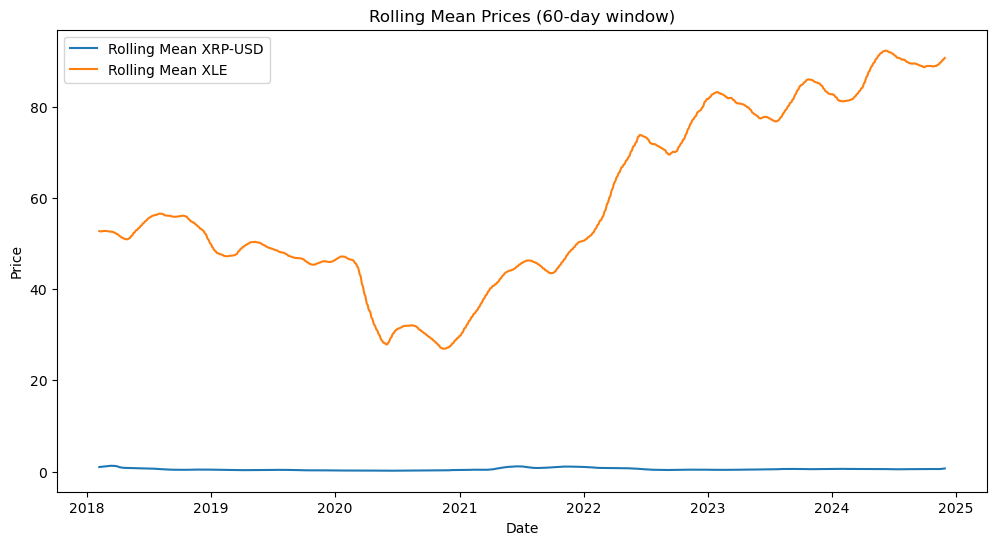

In [31]:
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class CorrelationAnalysis:
    def __init__(self, asset_tickers, target_ticker, start_date, end_date):
        if isinstance(asset_tickers, str):
            self.asset_tickers = [asset_tickers]
        else:
            self.asset_tickers = asset_tickers
        self.target_ticker = target_ticker

        self.asset_data = yf.download(self.asset_tickers, start=start_date, end=end_date, interval='1d')['Adj Close'].dropna()
        self.target_data = yf.download(self.target_ticker, start=start_date, end=end_date, interval='1d')['Adj Close'].dropna()

        self.data = pd.concat([self.asset_data, self.target_data], axis=1, join='inner')
        self.data.columns = self.asset_tickers + [self.target_ticker]

    def compute_correlation(self):
        corr_matrix = self.data.corr()
        return corr_matrix

    def plot_correlation_matrix(self):
        corr_matrix = self.compute_correlation()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Matrix')
        plt.show()

    def plot_scatter(self):
        for asset in self.asset_tickers:
            plt.figure(figsize=(8,6))
            sns.scatterplot(x=self.data[asset], y=self.data[self.target_ticker])
            plt.title(f'Scatter Plot of {asset} Price vs {self.target_ticker} Price')
            plt.xlabel(f'{asset} Price')
            plt.ylabel(f'{self.target_ticker} Price')
            plt.show()

    def rolling_correlation(self, window=60):
        rolling_corrs = {}
        for asset in self.asset_tickers:
            rolling_corr = self.data[asset].rolling(window).corr(self.data[self.target_ticker])
            rolling_mean_asset = self.data[asset].rolling(window).mean()
            rolling_mean_target = self.data[self.target_ticker].rolling(window).mean()
            rolling_corrs[asset] = rolling_corr

            plt.figure(figsize=(12,6))
            plt.plot(rolling_corr.index, rolling_corr, label=f'Rolling Correlation {asset} vs {self.target_ticker}')
            plt.title(f'Rolling Correlation ({window}-day window)')
            plt.xlabel('Date')
            plt.ylabel('Correlation')
            plt.legend()
            plt.show()

            plt.figure(figsize=(12,6))
            plt.plot(rolling_mean_asset.index, rolling_mean_asset, label=f'Rolling Mean {asset}')
            plt.plot(rolling_mean_target.index, rolling_mean_target, label=f'Rolling Mean {self.target_ticker}')
            plt.title(f'Rolling Mean Prices ({window}-day window)')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.show()
        return rolling_corrs

asset_tickers = ['BTC-USD', 'ETH-USD', 'XRP-USD']
target_ticker = 'XLE'  

start_date = '2010-01-01'
end_date = '2024-12-02'

corr_analysis = CorrelationAnalysis(asset_tickers, target_ticker, start_date, end_date)

correlation_matrix = corr_analysis.compute_correlation()
print("Correlation Matrix:")
print(correlation_matrix)

corr_analysis.plot_correlation_matrix()

corr_analysis.plot_scatter()

rolling_correlations = corr_analysis.rolling_correlation(window=60)


In [5]:
import requests
import pandas as pd


crypto_id = 'bitcoin'  

# Step 2: Fetch current data using CoinGecko API
api_url = f"https://api.coingecko.com/api/v3/coins/{crypto_id}"
response = requests.get(api_url)

if response.status_code == 200:
    data = response.json()
    
    current_price = data['market_data']['current_price']['usd']
    market_cap = data['market_data']['market_cap']['usd']
    circulating_supply = data['market_data']['circulating_supply']
else:
    print("Failed to retrieve data from CoinGecko API")
    exit()

print(f"Current Price: ${current_price:.4f}")
print(f"Market Cap: ${market_cap:,.2f}")
print(f"Circulating Supply: {circulating_supply:,.0f} coins\n")


def project_market_cap(current_market_cap, growth_rate, years):
    return current_market_cap * (1 + growth_rate) ** years


growth_rates = [0.10, 0.15, 0.20, 0.25,0.90]  
years = [1, 2, 3, 4, 5]  


results_list = []

for rate in growth_rates:
    for year in years:
        projected_cap = project_market_cap(market_cap, rate, year)
        projected_price = projected_cap / circulating_supply
        results_list.append({
            'Growth Rate': f"{int(rate * 100)}%",
            'Year': year,
            'Projected Market Cap': f"${projected_cap:,.2f}",
            'Projected Price': f"${projected_price:.4f}"
        })


results = pd.DataFrame(results_list)


print("Sensitivity Analysis Results:")
print(results)


Current Price: $94897.0000
Market Cap: $1,880,866,360,343.00
Circulating Supply: 19,790,568 coins

Sensitivity Analysis Results:
   Growth Rate  Year    Projected Market Cap Projected Price
0          10%     1   $2,068,952,996,377.30    $104542.3758
1          10%     2   $2,275,848,296,015.03    $114996.6133
2          10%     3   $2,503,433,125,616.53    $126496.2747
3          10%     4   $2,753,776,438,178.19    $139145.9021
4          10%     5   $3,029,154,081,996.01    $153060.4924
5          15%     1   $2,162,996,314,394.45    $109294.3019
6          15%     2   $2,487,445,761,553.62    $125688.4472
7          15%     3   $2,860,562,625,786.66    $144541.7143
8          15%     4   $3,289,647,019,654.66    $166222.9715
9          15%     5   $3,783,094,072,602.86    $191156.4172
10         20%     1   $2,257,039,632,411.60    $114046.2281
11         20%     2   $2,708,447,558,893.92    $136855.4737
12         20%     3   $3,250,137,070,672.70    $164226.5685
13         20%   

Bitcoin
ID: 'bitcoin'
Ethereum
ID: 'ethereum'
Tether
ID: 'tether'
Binance Coin (BNB)
ID: 'binancecoin'
USD Coin
ID: 'usd-coin'
XRP
ID: 'ripple'
Cardano
ID: 'cardano'
Solana
ID: 'solana'
Dogecoin
ID: 'dogecoin'
TRON
ID: 'tron'

Basic Info. S&P 500 Market Cap is at a current level of 45.84T, up from 44.08T last month and up from 37.16T one year ago.
